In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import scanpy as sc

import os
from tqdm import tqdm
from pathlib import Path

In [2]:
base_dir = Path().resolve().parent.parent
base_dir

PosixPath('/home/sadegh/python_projects/teesside/nanostring-cosmx-spatial-omics-modeling')

In [3]:
df = pd.read_csv(base_dir / 'data/All_Metabolic_Tasks.csv')
df

,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,Arginine synthesis,...,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,Subject_ID,Treatment_Status,Cell_ID,Cell_type,x,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1182412B,Untreated,TMA2_1_303,Malignant,-481975.375698,8092.453408
1,3.596589,3.596589,1.593463,3.596589,2.363587,3.596589,1.388632,1.666016,2.688572,3.596589,...,3.596589,1.506556,0.828416,1.506556,1182412B,Untreated,TMA2_3_303,Malignant,-481865.375698,7851.453408
2,1.262172,1.262172,0.683991,1.262172,2.010341,1.262172,0.736895,0.736804,0.653205,1.262172,...,1.262172,3.839008,0.379129,3.839008,1182412B,Untreated,TMA2_6_303,Malignant,-480421.375698,6738.453408
3,0.941260,0.941260,0.617541,0.941260,0.652265,0.941260,0.764453,0.736154,0.465586,0.941260,...,0.941260,1.021286,0.348070,1.021286,1182412B,Untreated,TMA2_8_303,Malignant,-480420.375698,6614.453408
4,18.998492,18.998492,5.560580,18.998492,5.922492,18.998492,1.621913,5.685172,7.343501,18.998492,...,18.998492,2.281059,2.585627,2.281059,1182412B,Untreated,TMA2_9_303,Malignant,-480494.375698,6607.453408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139956,0.000000,0.000000,0.000000,0.000000,0.065008,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.252118,0.000000,0.252118,1185092B,Untreated,TMA2_223_302,Plasma_IgG,-470201.968263,-72967.018989
2139957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.942360,0.544111,5.942360,1185092B,Untreated,TMA2_231_302,Plasma_IgG,-470619.968263,-73036.018989
2139958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051084,0.000000,0.000000,...,0.000000,0.375187,0.054611,0.375187,1185092B,Untreated,TMA2_236_302,Plasma_IgG,-470193.968263,-73111.018989
2139959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1185092B,Untreated,TMA2_238_302,Fib_ECM,-469892.968263,-73112.018989


In [4]:
df.columns

Index(['(R)-3-Hydroxybutanoate synthesis',
       'ATP generation from glucose (hypoxic conditions) - glycolysis',
       'ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
       'Acetoacetate synthesis', 'Alanine degradation', 'Alanine synthesis',
       'Arachidonate degradation', 'Arachidonate synthesis',
       'Arginine degradation', 'Arginine synthesis',
       ...
       'beta-Alanine synthesis', 'cis-vaccenic acid degradation',
       'cis-vaccenic acid synthesis', 'gamma-Linolenate degradation',
       'Subject_ID', 'Treatment_Status', 'Cell_ID', 'Cell_type', 'x', 'y'],
      dtype='object', length=106)

In [5]:
len(df[df["Cell_type"].str.startswith("Malignant")])

984808

In [6]:
tasks_meta_data = pd.read_csv(base_dir / 'data/Task_Info_with_CRC_binary.csv')
tasks_meta_data

,Task,System,Subsystem,Upregulated_in_CRC
0,(R)-3-Hydroxybutanoate synthesis,CARBOHYDRATES METABOLISM,KETOGENESIS,0
1,3'-Phospho-5'-adenylyl sulfate synthesis,NUCLEOTIDE METABOLISM,COFACTOR,0
2,AMP salvage from adenine,NUCLEOTIDE METABOLISM,SALVAGE,0
3,ATP generation from glucose (hypoxic condition...,ENERGY METABOLISM,ATP GENERATION,1
4,ATP regeneration from glucose (normoxic condit...,ENERGY METABOLISM,ATP GENERATION,0
...,...,...,...,...
213,Synthesis of androstenedione from cholesterol,HORMONES METABOLISM,ANDROGEN METABOLISM,0
214,Synthesis of estradiol-17beta (E2) from andros...,HORMONES METABOLISM,ESTROGEN METABOLISM,0
215,Synthesis of estrone (E1) from androstenedione,HORMONES METABOLISM,ESTROGEN METABOLISM,0
216,Synthesis of progesterone from cholesterol,HORMONES METABOLISM,PROGESTERONE METABOLISM,0


In [7]:
tasks_meta_data.columns

Index(['Task', 'System', 'Subsystem', 'Upregulated_in_CRC'], dtype='object')

In [8]:
meta_cols = ["Subject_ID", "Treatment_Status", "Cell_ID", "Cell_type", "x", "y"]
task_cols = [c for c in df.columns if c not in meta_cols]

In [9]:
cell_type_masks = {
    "Macrophage": df["Cell_type"].str.startswith("Mph_"),
    "Fibroblast": df["Cell_type"].str.startswith("Fib_"),
    "Malignant": df["Cell_type"] == "Malignant"
}

In [10]:
def ttest_metabolic_tasks(
    df,
    task_cols,
    cell_mask,
    task_meta_df,
    alpha=0.05,
    pseudocount=1e-6
):
    out = []

    sub = df[cell_mask]

    treated = sub[sub["Treatment_Status"] == "Treated"]
    control = sub[sub["Treatment_Status"] == "Untreated"]

    for task in task_cols:
        t_stat, p_val = ttest_ind(
            treated[task],
            control[task],
            equal_var=False,
            nan_policy="omit"
        )

        mean_treated = treated[task].mean()
        mean_control = control[task].mean()

        std_treated = treated[task].std()
        std_control = control[task].std()

        fold_change = (mean_treated + pseudocount) / (mean_control + pseudocount)
        log2_fc = np.log2(fold_change)

        out.append({
            "Task": task,

            "mean_treated": mean_treated,
            "std_treated": std_treated,

            "mean_untreated": mean_control,
            "std_untreated": std_control,

            "fold_change": fold_change,
            "log2_fold_change": log2_fc,

            "t_stat": t_stat,
            "p_value": p_val,
            "significant": p_val < alpha,

            "n_treated": treated.shape[0],
            "n_untreated": control.shape[0],
        })

    res_df = pd.DataFrame(out)

    # add System & Subsystem
    res_df = res_df.merge(
        task_meta_df[["Task", "System", "Subsystem"]],
        on="Task",
        how="left"
    )

    return res_df


In [11]:
results = []

for ct_name, mask in cell_type_masks.items():
    res = ttest_metabolic_tasks(df, task_cols, mask, tasks_meta_data)
    res["cell_type_group"] = ct_name
    results.append(res)

df_results = pd.concat(results, ignore_index=True)
df_results

,Task,mean_treated,std_treated,mean_untreated,std_untreated,fold_change,log2_fold_change,t_stat,p_value,significant,n_treated,n_untreated,System,Subsystem,cell_type_group
0,(R)-3-Hydroxybutanoate synthesis,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,CARBOHYDRATES METABOLISM,KETOGENESIS,Macrophage
1,ATP generation from glucose (hypoxic condition...,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,ENERGY METABOLISM,ATP GENERATION,Macrophage
2,ATP regeneration from glucose (normoxic condit...,1.478084,1.423018,1.545478,1.510595,0.956393,-0.064325,-7.900555,2.800326e-15,True,57303,60968,ENERGY METABOLISM,ATP GENERATION,Macrophage
3,Acetoacetate synthesis,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,LIPIDS METABOLISM,CHOLESTEROL METABOLISM,Macrophage
4,Alanine degradation,3.093847,1.882766,3.170343,2.000646,0.975871,-0.035237,-6.774380,1.255224e-11,True,57303,60968,AMINO ACIDS METABOLISM,ALANINE METABOLISM,Macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,beta-Alanine degradation,2.011636,1.205713,2.016535,1.314903,0.997571,-0.003509,-1.909711,5.617070e-02,False,402496,582312,AMINO ACIDS METABOLISM,BETA-ALANINE METABOLISM,Malignant
296,beta-Alanine synthesis,4.613928,4.085710,4.142144,4.239875,1.113899,0.155618,55.467718,0.000000e+00,True,402496,582312,AMINO ACIDS METABOLISM,BETA-ALANINE METABOLISM,Malignant
297,cis-vaccenic acid degradation,3.269476,1.886264,2.793333,1.978828,1.170457,0.227072,120.690272,0.000000e+00,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM,Malignant
298,cis-vaccenic acid synthesis,1.092658,0.658557,1.002718,0.684241,1.089697,0.123927,65.569171,0.000000e+00,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM,Malignant


In [12]:
df_results.columns

Index(['Task', 'mean_treated', 'std_treated', 'mean_untreated',
       'std_untreated', 'fold_change', 'log2_fold_change', 't_stat', 'p_value',
       'significant', 'n_treated', 'n_untreated', 'System', 'Subsystem',
       'cell_type_group'],
      dtype='object')

In [13]:
sig_counts = (
    df_results[df_results['significant']]
    .groupby('cell_type_group')
    .size()
    .reset_index(name='n_significant')
)
sig_counts

,cell_type_group,n_significant
0,Fibroblast,81
1,Macrophage,96
2,Malignant,96


In [14]:
def plot_tasks_by_celltype(df, cell_type, top_n=10):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    up = (
        sub[sub["log2_fold_change"] > 0]
        .sort_values("log2_fold_change", ascending=False)
        .head(top_n)
    )

    down = (
        sub[sub["log2_fold_change"] < 0]
        .sort_values("log2_fold_change")
        .head(top_n)
    )

    plot_df = (
        pd.concat([up, down])
        .sort_values("log2_fold_change")
    )

    colors = plot_df["log2_fold_change"].apply(
        lambda x: "red" if x > 0 else "blue"
    )

    plt.figure(figsize=(8, 4))
    plt.barh(plot_df["Task"], plot_df["log2_fold_change"])

    for bar, c in zip(plt.gca().patches, colors):
        bar.set_color(c)

    plt.axvline(0)
    plt.xlabel("log2FC (Treated vs Untreated)")
    plt.title(f"Differential Metabolic Tasks – {cell_type}")
    plt.tight_layout()
    plt.show()

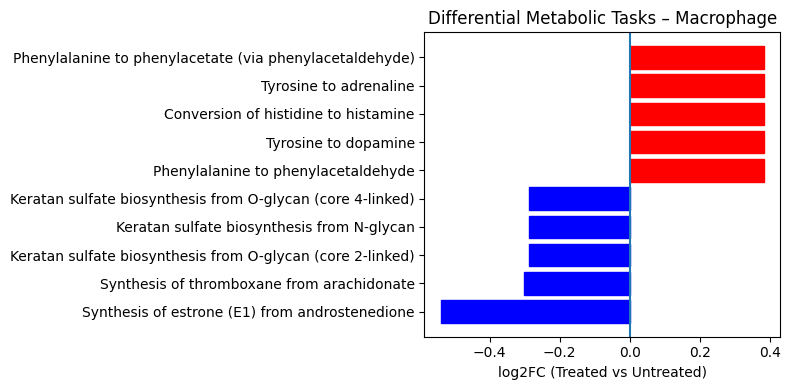

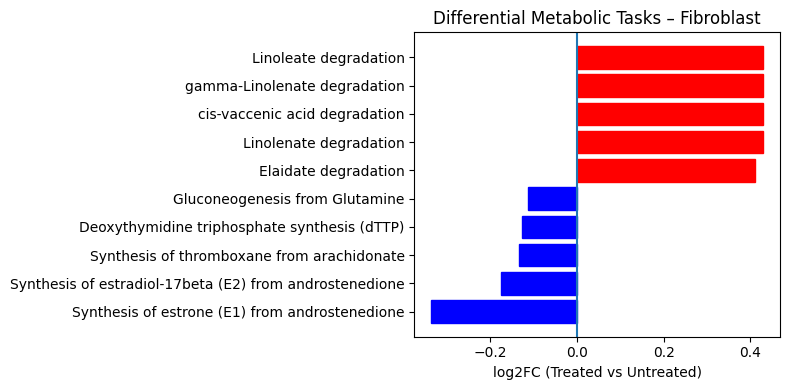

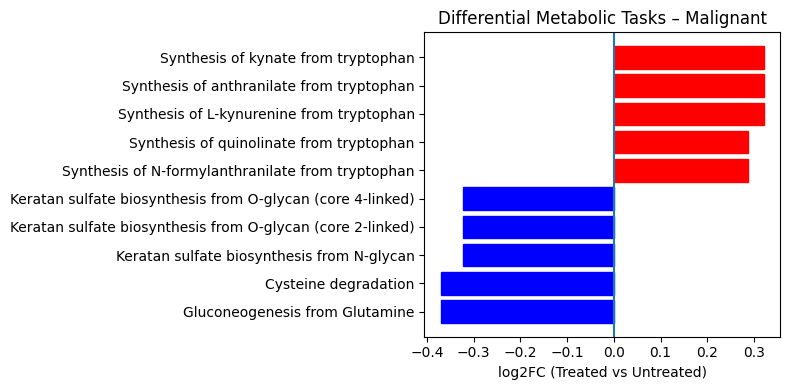

In [15]:
for ct in df_results["cell_type_group"].unique():
    plot_tasks_by_celltype(df_results, ct, 5)

In [16]:
def count_significant_tasks_by_system(df, cell_type):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    counts = (
        sub.groupby("System")
        .size()
        .reset_index(name="n_significant_tasks")
        .sort_values("n_significant_tasks", ascending=False)
    )

    return counts

In [17]:
def plot_system_counts(df, cell_type):
    counts = count_significant_tasks_by_system(df, cell_type)
    counts = counts.sort_values("n_significant_tasks")

    plt.figure(figsize=(8, 4))

    bars = plt.barh(
        counts["System"],
        counts["n_significant_tasks"],
        alpha=0.85
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.1,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            va="center",
            fontsize=9
        )

    plt.xlabel("Number of significantly different tasks", fontsize=10)
    plt.title(
        f"Significant Metabolic Tasks per System\n({cell_type}s)",
        fontsize=11
    )

    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
def plot_subsystem_counts(df, cell_type, top_n=15):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    counts = (
        sub.groupby("Subsystem")
        .size()
        .reset_index(name="n_significant_tasks")
        .sort_values("n_significant_tasks", ascending=False)
        .head(top_n)
        .sort_values("n_significant_tasks")
    )

    plt.figure(figsize=(8, 5))

    bars = plt.barh(
        counts["Subsystem"],
        counts["n_significant_tasks"],
        alpha=0.85
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.1,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            va="center",
            fontsize=9
        )

    plt.xlabel("Number of significantly different tasks", fontsize=10)
    plt.title(
        f"Significant Metabolic Tasks per Subsystem\n({cell_type}s)",
        fontsize=11
    )

    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()



Cell type: Macrophage


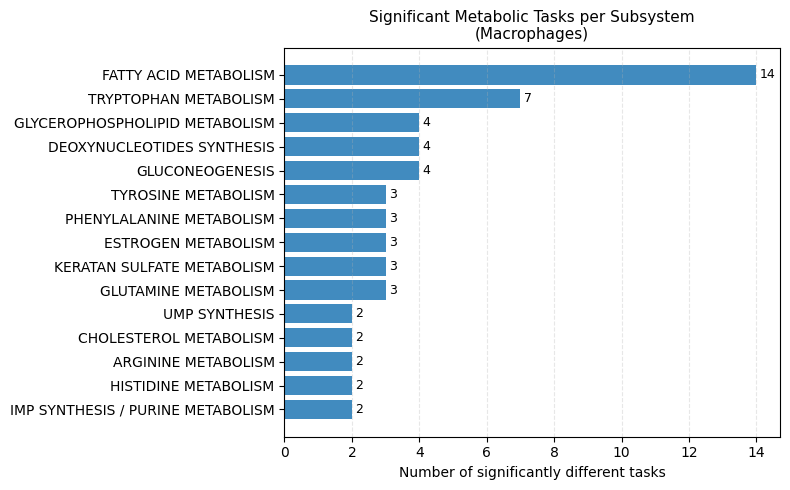

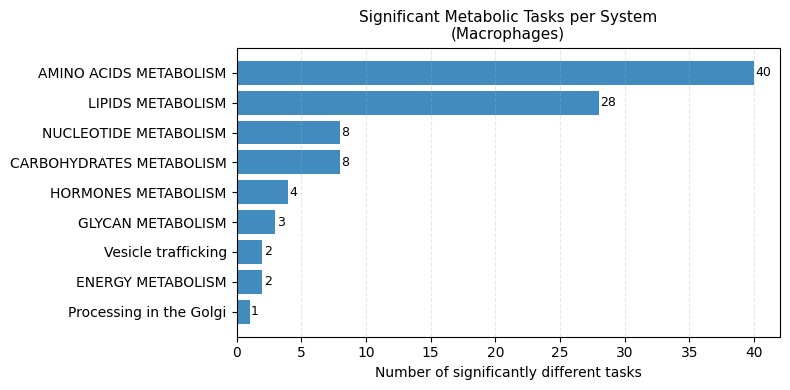


Cell type: Fibroblast


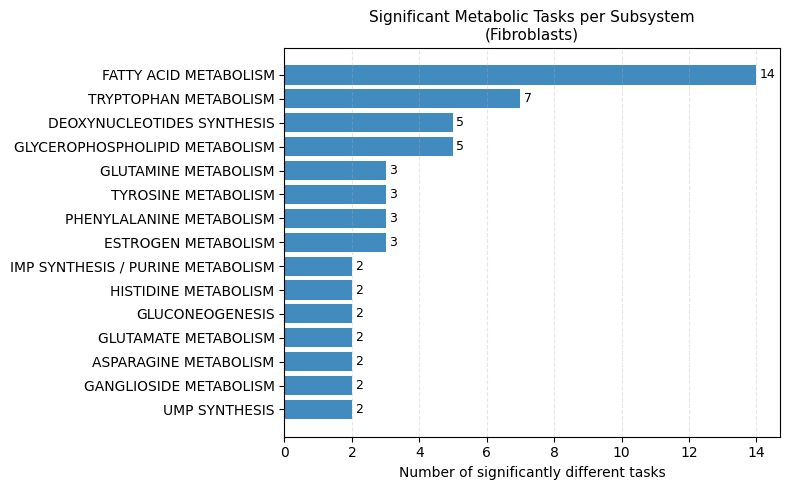

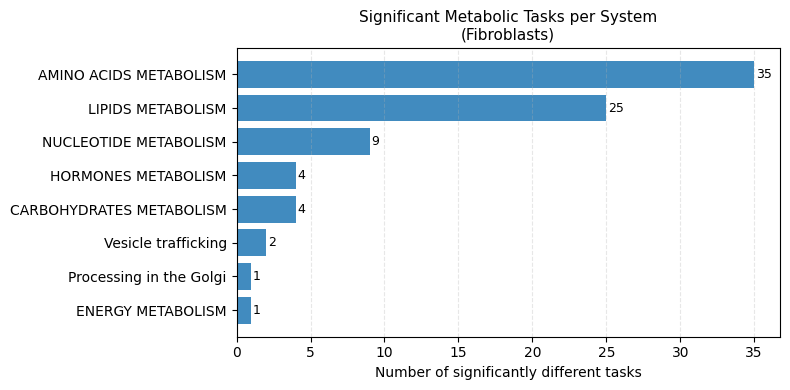


Cell type: Malignant


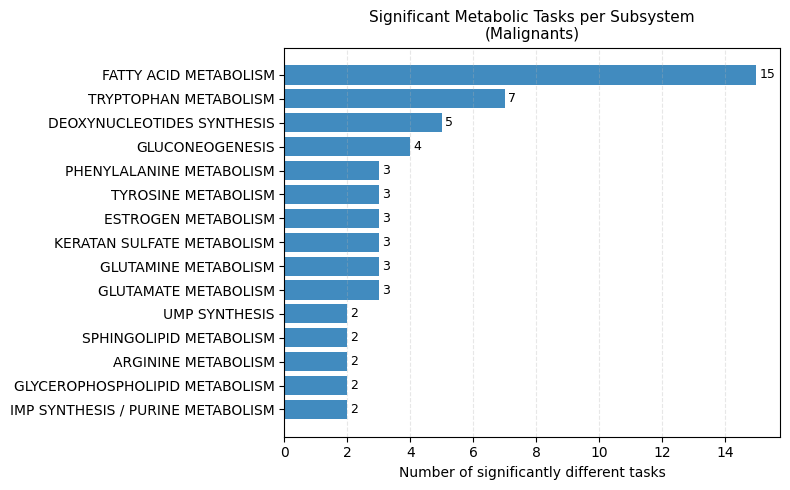

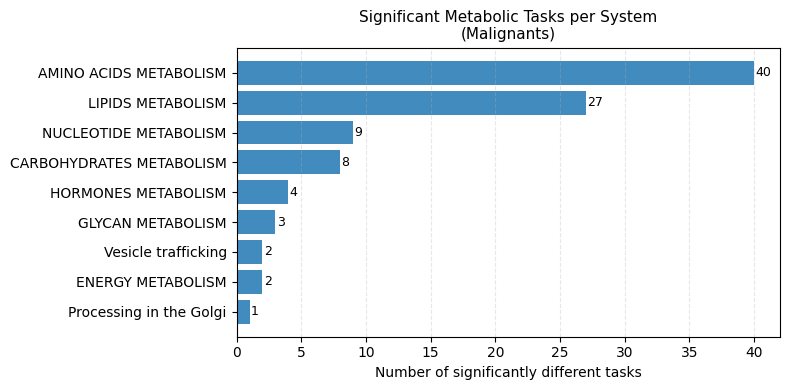

In [19]:
for ct in df_results["cell_type_group"].unique():
    print(f"\nCell type: {ct}")
    plot_subsystem_counts(df_results, ct)
    plot_system_counts(df_results, ct)

## Tumor Infilitrating T-Cell Score Calculation

In [20]:
input_root = base_dir / "sccellfie_results"
output_root = base_dir / "metabolic_tasks_and_reaction_with_TNKscore"

os.makedirs(output_root, exist_ok=True)

patients = [p for p in os.listdir(input_root)
            if os.path.isdir(os.path.join(input_root, p))]

for pid in tqdm(patients):

    out_dir = os.path.join(output_root, pid)
    out_path = os.path.join(out_dir, f"{pid}_with_TNKscore.h5ad")

    if os.path.exists(out_path):
        print(f"Skipping {pid} (already processed)")
        continue

    try:
        print(f"Processing {pid}")

        # paths
        adata_path = os.path.join(input_root, pid, f"{pid}.h5ad")
        task_path  = os.path.join(input_root, pid, f"{pid}_metabolic_tasks.h5ad")
        rxn_path   = os.path.join(input_root, pid, f"{pid}_reactions.h5ad")

        # load
        adata = sc.read_h5ad(adata_path)
        adata_tasks = sc.read_h5ad(task_path)
        adata_rxn = sc.read_h5ad(rxn_path)

        # attach matrices
        adata.obsm["met_tasks"] = adata_tasks.X
        adata.uns["met_task_names"] = list(adata_tasks.var_names)

        adata.obsm["rxn"] = adata_rxn.X
        adata.uns["rxn_names"] = list(adata_rxn.var_names)

        # neighborhood + labels
        conn = adata.obsp["neighbors_30_connectivities"]
        labels = adata.obs["Lineage_level3"]

        is_tnk = labels == "T_NK"
        is_malignant = labels == "Malignant"

        mal_score = np.zeros(adata.n_obs)
        tnk_idx = np.where(is_tnk)[0]

        for i in tnk_idx:
            neighbors = conn[i].nonzero()[1]
            mal_neighbors = neighbors[is_malignant.iloc[neighbors].values]
            mal_score[i] = len(mal_neighbors) / 30.0

        adata.obs["TNK_MalignantScore"] = mal_score

        # save
        os.makedirs(out_dir, exist_ok=True)
        adata.write(out_path)

    except Exception as e:
        print(f"FAILED on {pid}: {e}")

100%|██████████| 24/24 [00:00<00:00, 24227.03it/s]

Skipping 1182412B (already processed)
Skipping 118223A (already processed)
Skipping 468115 (already processed)
Skipping 1258057B (already processed)
Skipping 120139 (already processed)
Skipping 114262 (already processed)
Skipping 1182623B (already processed)
Skipping 1228762B (already processed)
Skipping 1204245B (already processed)
Skipping 120153 (already processed)
Skipping 1180097B (already processed)
Skipping 95278A2 (already processed)
Skipping 1207356B (already processed)
Skipping 1209622B (already processed)
Skipping 120140 (already processed)
Skipping 120136 (already processed)
Skipping 92604 (already processed)
Skipping 78410A1 (already processed)
Skipping 120149 (already processed)
Skipping 1216278B (already processed)
Skipping 89397 (already processed)
Skipping 1192325B (already processed)
Skipping 120161 (already processed)
Skipping 1185092B (already processed)


In [21]:
input_root = base_dir / "sccellfie_results"
THRESHOLD = 0.2

records = []

patients = [
    p for p in os.listdir(input_root)
    if os.path.isdir(os.path.join(input_root, p))
]

for pid in tqdm(patients):
    try:
        adata_path = os.path.join(input_root, pid, f"{pid}.h5ad")
        task_path  = os.path.join(input_root, pid, f"{pid}_metabolic_tasks.h5ad")
        rxn_path   = os.path.join(input_root, pid, f"{pid}_reactions.h5ad")

        adata = sc.read_h5ad(adata_path)
        adata_tasks = sc.read_h5ad(task_path)
        adata_rxn = sc.read_h5ad(rxn_path)

        # attach matrices (for consistency)
        adata.obsm["met_tasks"] = adata_tasks.X
        adata.obsm["rxn"] = adata_rxn.X

        conn = adata.obsp["neighbors_30_connectivities"]
        labels = adata.obs["Lineage_level3"]

        is_tnk = labels == "T_NK"
        is_malignant = labels == "Malignant"

        tnk_idx = np.where(is_tnk)[0]

        mal_score = np.zeros(len(tnk_idx))
        for j, i in enumerate(tnk_idx):
            neighbors = conn[i].nonzero()[1]
            mal_neighbors = neighbors[is_malignant.iloc[neighbors].values]
            mal_score[j] = len(mal_neighbors) / 30.0

        n_tnk = len(tnk_idx)
        n_tnk_infil = int(np.sum(mal_score >= THRESHOLD))

        # treatment status (assuming one per patient)
        treatment_status = (
            adata.obs["Treatment_Status"].iloc[0]
            if "Treatment_Status" in adata.obs.columns
            else "Unknown"
        )

        records.append({
            "patient_id": pid,
            "treatment_status": treatment_status,
            "TNK_total": n_tnk,
            "TNK_infiltrating": n_tnk_infil,
            "TNK_infiltrating_ratio": (
                n_tnk_infil / n_tnk if n_tnk > 0 else 0
            )
        })

    except Exception as e:
        records.append({
            "patient_id": pid,
            "treatment_status": "FAILED",
            "TNK_total": np.nan,
            "TNK_infiltrating": np.nan,
            "TNK_infiltrating_ratio": np.nan,
            "error": str(e)
        })

# final dataframe
df_tnk = pd.DataFrame(records)
df_tnk

100%|██████████| 24/24 [02:50<00:00,  7.11s/it]


,patient_id,treatment_status,TNK_total,TNK_infiltrating,TNK_infiltrating_ratio
0,1182412B,Untreated,950,69,0.072632
1,118223A,Untreated,2257,104,0.046079
2,468115,Treated,6873,133,0.019351
3,1258057B,Untreated,5568,436,0.078305
4,120139,Treated,1068,14,0.013109
5,114262,Treated,295,188,0.637288
6,1182623B,Untreated,2811,175,0.062255
7,1228762B,Untreated,979,12,0.012257
8,1204245B,Untreated,475,1,0.002105
9,120153,Treated,7617,719,0.094394


In [22]:
df_tnk.groupby("treatment_status")["TNK_infiltrating"].sum()

treatment_status
Treated      2595
Untreated    3159
Name: TNK_infiltrating, dtype: int64

## T-Cell Infilitrating Analysis

In [23]:
sig_tasks = (
    df_results
    .sort_values("p_value")
    .groupby("cell_type_group")
    .first()
)
sig_tasks

,Task,mean_treated,std_treated,mean_untreated,std_untreated,fold_change,log2_fold_change,t_stat,p_value,significant,n_treated,n_untreated,System,Subsystem
cell_type_group,,,,,,,,,,,,,,
Fibroblast,gamma-Linolenate degradation,3.536826,2.289270,2.624318,2.239936,1.347712,0.430513,114.828191,0.0,True,134047,208585,LIPIDS METABOLISM,FATTY ACID METABOLISM
Macrophage,Elaidate degradation,3.567529,1.826031,2.982544,1.940226,1.196136,0.258382,53.416306,0.0,True,57303,60968,LIPIDS METABOLISM,FATTY ACID METABOLISM
Malignant,gamma-Linolenate degradation,3.269476,1.886264,2.793333,1.978828,1.170457,0.227072,120.690272,0.0,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM


In [ ]:
# sig_tasks.to_csv('Selected_Significant_Task_per_celltype.csv')

In [24]:
def compute_colocalization_per_patient(
    adata,
    sig_tasks,
    infiltration_thr=0.0
):
    labels = adata.obs["Lineage_level3"]
    conn = adata.obsp["neighbors_30_connectivities"]

    task_names = list(adata.uns["met_task_names"])
    task_mat = adata.obsm["met_tasks"]

    is_tnk = labels == "T_NK"
    is_infil = adata.obs["TNK_MalignantScore"] > infiltration_thr

    tnk_infil_idx = np.where(is_tnk & is_infil)[0]

    results = {}

    for cell_type, row in sig_tasks.iterrows():
        task = row["Task"]

        if task not in task_names:
            results[cell_type] = np.nan
            continue

        tidx = task_names.index(task)

        if cell_type == "Macrophage":
            mask = labels.str.startswith("Macrophage")
        elif cell_type == "Fibroblast":
            mask = labels.str.startswith("Fibroblast")
        elif cell_type == "Malignant":
            mask = labels == "Malignant"
        else:
            continue

        coloc_vals = []

        for i in tnk_infil_idx:
            neigh = conn[i].nonzero()[1]
            ct_neigh = neigh[mask.iloc[neigh].values]

            if len(ct_neigh) > 0:
                coloc_vals.append(task_mat[ct_neigh, tidx].mean())
        

        results[f"{cell_type}_coloc_{task}"] = (
            np.mean(coloc_vals) if len(coloc_vals) > 0 else np.nan
        )

    return results

In [25]:
input_root = "metabolic_tasks_and_reaction_with_TNKscore"

all_results = []

for pid in os.listdir(input_root):
    adata_path = os.path.join(
        input_root, pid, f"{pid}_with_TNKscore.h5ad"
    )
    if not os.path.exists(adata_path):
        continue

    adata = sc.read_h5ad(adata_path)

    if "Treatment_Status" not in adata.obs.columns:
        continue

    for treatment_status in adata.obs["Treatment_Status"].unique():

        adata_sub = adata[
            adata.obs["Treatment_Status"] == treatment_status
        ].copy()

        res = compute_colocalization_per_patient(
            adata_sub,
            sig_tasks,
            infiltration_thr=0.2
        )

        if res is None:
            continue

        res["patient_id"] = pid
        res["Treatment_Status"] = treatment_status

        all_results.append(res)

df_coloc = pd.DataFrame(all_results)


In [26]:
df_coloc

,Fibroblast_coloc_gamma-Linolenate degradation,Macrophage_coloc_Elaidate degradation,Malignant_coloc_gamma-Linolenate degradation,patient_id,Treatment_Status
0,0.588416,1.627540,2.017976,1182412B,Untreated
1,3.628914,2.044408,3.358103,118223A,Untreated
2,4.335850,5.518390,3.340702,468115,Treated
3,2.056310,1.490430,2.002581,1258057B,Untreated
4,3.784052,2.877779,2.647227,120139,Treated
5,6.808839,5.086785,6.446181,114262,Treated
6,3.601582,2.695925,3.300344,1182623B,Untreated
7,2.748146,2.358712,1.721462,1228762B,Untreated
8,NaN,NaN,5.454919,1204245B,Untreated
9,6.414532,5.424241,4.727656,120153,Treated


In [ ]:
# df_coloc.to_csv('coloc_sig_tasks_with_TNK_cells.csv',index=False)

In [27]:
plot_df = df_coloc.melt(
    id_vars=["patient_id", "Treatment_Status"],
    value_vars=[
        "Malignant_coloc_gamma-Linolenate degradation",
        "Macrophage_coloc_Elaidate degradation",
        "Fibroblast_coloc_gamma-Linolenate degradation"
    ],
    var_name="CellTask",
    value_name="Metabolic task activity"
)

plot_df["Cell type"] = plot_df["CellTask"].str.extract(
    r"(Malignant|Macrophage|Fibroblast)"
)

plot_df["Task"] = plot_df["CellTask"].str.replace(
    r".*_coloc_", "", regex=True
)

plot_df["Label"] = (
    plot_df["Cell type"] + "\n(" + plot_df["Task"] + ")"
)

In [28]:
celltype_map = {
    "Malignant": "malignant cells",
    "Macrophage": "macrophages",
    "Fibroblast": "fibroblasts"
}

plot_df["Cell type"] = plot_df["Cell type"].map(celltype_map)

In [29]:
plot_df["Label"] = (
    plot_df["Cell type"] + "\n(Task: " + plot_df["Task"] + ")"
)

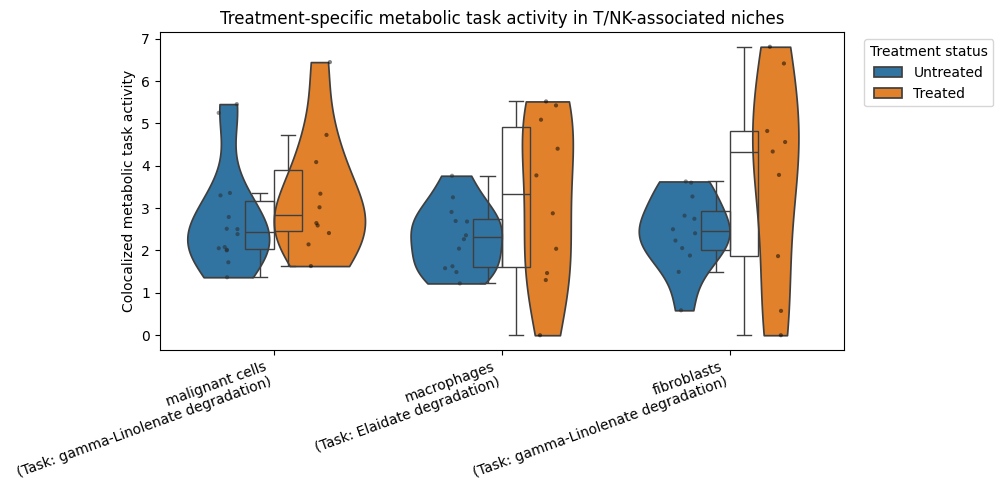

In [30]:
plt.figure(figsize=(10,5)) 

sns.violinplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    cut=0,
    inner=None,
    dodge=True
)

sns.boxplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    width=0.25,
    showcaps=True,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    dodge=True
)

sns.stripplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    dodge=True,
    color="black",
    size=3,
    alpha=0.5
)

plt.ylabel("Colocalized metabolic task activity")
plt.xlabel("")
plt.title("Treatment-specific metabolic task activity in T/NK-associated niches")

plt.xticks(rotation=20, ha="right")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2],
    labels[:2],
    title="Treatment status",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


### Count based analysis

In [31]:
def count_cells_colocalized_with_TNK(
    adata,
    infiltration_thr=0.0
):
    labels = adata.obs["Lineage_level3"]
    conn = adata.obsp["neighbors_30_connectivities"]

    is_tnk = labels == "T_NK"
    is_infil = adata.obs["TNK_MalignantScore"] > infiltration_thr
    tnk_infil_idx = np.where(is_tnk & is_infil)[0]

    if len(tnk_infil_idx) == 0:
        return None

    masks = {
        "Malignant": labels == "Malignant",
        "Macrophage": labels.str.startswith("Macrophage"),
        "Fibroblast": labels.str.startswith("Fibroblast"),
    }

    results = {}

    for ct, mask in masks.items():
        total_cells = np.sum(mask)

        if total_cells == 0:
            results[f"{ct}_n_total"] = 0
            results[f"{ct}_n_coloc"] = 0
            results[f"{ct}_pct_coloc"] = np.nan
            continue

        coloc_cells = set()

        for i in tnk_infil_idx:
            neigh = conn[i].nonzero()[1]
            ct_neigh = neigh[mask.iloc[neigh].values]
            coloc_cells.update(ct_neigh.tolist())

        n_coloc = len(coloc_cells)

        results[f"{ct}_n_total"] = total_cells
        results[f"{ct}_n_coloc"] = n_coloc
        results[f"{ct}_pct_coloc"] = n_coloc / total_cells

    return results


In [32]:
input_root = "metabolic_tasks_and_reaction_with_TNKscore"

all_rows = []

for pid in os.listdir(input_root):
    adata_path = os.path.join(
        input_root, pid, f"{pid}_with_TNKscore.h5ad"
    )
    if not os.path.exists(adata_path):
        continue

    adata = sc.read_h5ad(adata_path)

    # sanity check
    if "Treatment_Status" not in adata.obs.columns:
        continue

    for treatment_status in adata.obs["Treatment_Status"].unique():

        adata_sub = adata[adata.obs["Treatment_Status"] == treatment_status].copy()

        res = count_cells_colocalized_with_TNK(
            adata_sub,
            infiltration_thr=0.0
        )

        if res is None:
            continue

        res["patient_id"] = pid
        res["Treatment_Status"] = treatment_status

        all_rows.append(res)

df_counts = pd.DataFrame(all_rows)


In [33]:
df_counts

,Malignant_n_total,Malignant_n_coloc,Malignant_pct_coloc,Macrophage_n_total,Macrophage_n_coloc,Macrophage_pct_coloc,Fibroblast_n_total,Fibroblast_n_coloc,Fibroblast_pct_coloc,patient_id,Treatment_Status
0,31596,1271,0.040227,8861,97,0.010947,14332,36,0.002512,1182412B,Untreated
1,49410,2036,0.041206,1579,72,0.045598,9514,143,0.015030,118223A,Untreated
2,86664,1980,0.022847,11518,383,0.033252,9535,140,0.014683,468115,Treated
3,10326,3007,0.291207,985,463,0.470051,7170,1036,0.144491,1258057B,Untreated
4,36789,297,0.008073,6146,40,0.006508,20256,12,0.000592,120139,Treated
5,2951,1748,0.592342,853,386,0.452521,893,315,0.352744,114262,Treated
6,71956,3042,0.042276,7691,891,0.115850,15058,968,0.064285,1182623B,Untreated
7,5818,285,0.048986,1388,119,0.085735,2286,11,0.004812,1228762B,Untreated
8,9146,11,0.001203,7255,0,0.000000,33885,0,0.000000,1204245B,Untreated
9,47733,6468,0.135504,17010,727,0.042740,46865,650,0.013870,120153,Treated


In [ ]:
# df_counts.to_csv('colocalization_with_TNK_Cells.csv', index=False)

In [34]:
plot_df = df_counts.melt(
    id_vars=["patient_id", "Treatment_Status"],
    value_vars=[
        "Malignant_pct_coloc",
        "Macrophage_pct_coloc",
        "Fibroblast_pct_coloc"
    ],
    var_name="Cell type",
    value_name="Proportion colocalized"
)

plot_df["Cell type"] = plot_df["Cell type"].str.replace("_pct_coloc", "")

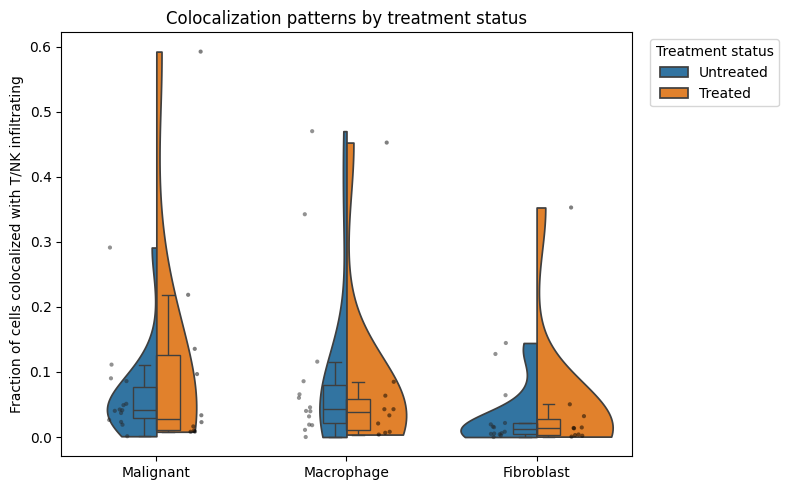

In [35]:
plt.figure(figsize=(8,5))

sns.violinplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    split=True,
    inner=None,
    cut=0
)

sns.boxplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    width=0.25,
    showcaps=True,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    dodge=True
)

sns.stripplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    dodge=True,
    color="black",
    size=3,
    alpha=0.5
)

plt.ylabel("Fraction of cells colocalized with T/NK infiltrating")
plt.xlabel("")
plt.title("Colocalization patterns by treatment status")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Treatment status", bbox_to_anchor=(1.02,1), loc="upper left")

plt.tight_layout()
plt.show()


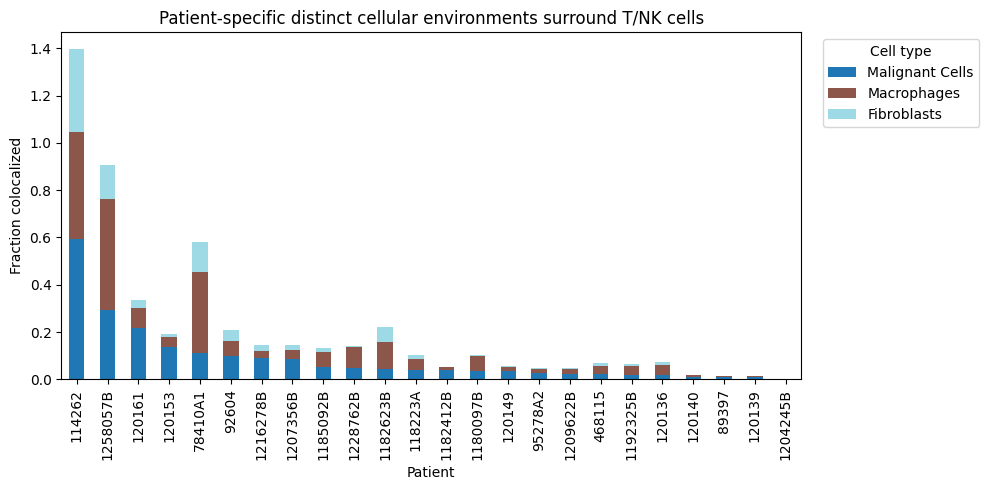

In [36]:
stack_df = df_counts.set_index("patient_id")[[
    "Malignant_pct_coloc",
    "Macrophage_pct_coloc",
    "Fibroblast_pct_coloc"
]]

stack_df = stack_df.sort_values("Malignant_pct_coloc", ascending=False)

stack_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    colormap="tab20"
)

plt.ylabel("Fraction colocalized")
plt.xlabel("Patient")
plt.title("Patient-specific distinct cellular environments surround T/NK cells")
plt.legend(
    title="Cell type",
    labels=["Malignant Cells","Macrophages","Fibroblasts"],
    bbox_to_anchor=(1.02,1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


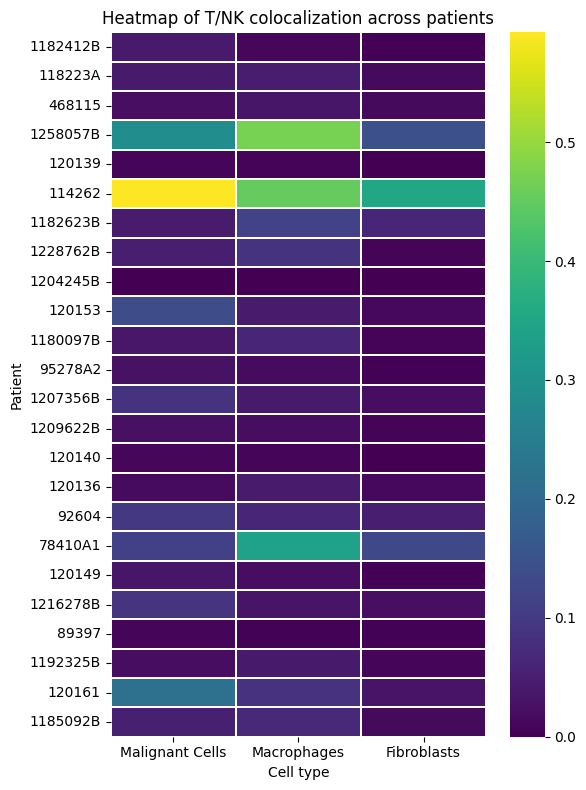

In [37]:
heat_df = df_counts.set_index("patient_id")[[
    "Malignant_pct_coloc",
    "Macrophage_pct_coloc",
    "Fibroblast_pct_coloc"
]]

plt.figure(figsize=(6,8))
ax = sns.heatmap(
    heat_df,
    cmap="viridis",
    linewidths=0.3
)

ax.set_xticklabels(
    ["Malignant Cells", "Macrophages", "Fibroblasts"],
    rotation=0
)

plt.title("Heatmap of T/NK colocalization across patients")
plt.ylabel("Patient")
plt.xlabel("Cell type")
plt.tight_layout()
plt.show()
